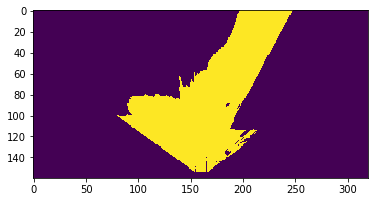

In [43]:
import numpy as np
import cv2
import matplotlib.image as mpimg
#import matplotlib.pyplot as plt


# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) & (img[:,:,1] > rgb_thresh[1]) & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# Define a function to convert from image pixel values to rover-centric pixel
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the
    # center bottom of the image.
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle)
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))

    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image

    return warped


# Apply the above functions in succession and update the Rover state accordingly
def perception_step(Rover):
    # Perform perception steps to update Rover()
    # TODO:
    # NOTE: camera image is coming to you in Rover.img
    # 1) Define source and destination points for perspective transform
    bottom_offset = 6
    dst_size = 5 
    image = Rover.img
    source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])

    # 2) Apply perspective transform
    warped_img = perspect_transform(Rover.img, source, destination)

    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    rgb_thresh_terrain = (160,160,160)
    rgb_thresh_rocksample = (0,0,0) # <-------------fix rgb values!
    rgb_thresh_obstacle = (0,0,0) # <-------------fix rgb values!

    terrain_img = color_thresh(warped_img, rgb_thresh_terrain)
    rocksample_img = color_thresh(warped_img, rgb_thresh_rocksample)
    obstacle_img = color_thresh(warped_img, rgb_thresh_obstacle)

    # 4) Update Rover.vision_image (this will be displayed on left side of screen)
    Rover.vision_image[:,:,0] = obstacle_img
    Rover.vision_image[:,:,1] = rocksample_img
    Rover.vision_image[:,:,2] = terrain_img

    # 5) Convert map image pixel values to rover-centric pixel
    x_pixel_t, y_pixel_t = rover_coords(terrain_img)
    x_pixel_r, y_pixel_r = rover_coords(rocksample_img)
    x_pixel_o, y_pixel_o = rover_coords(obstacle_img)

    # 6) Convert rover-centric pixel values to world coordinates
    x_world_t, y_world_t = pix_to_world(x_pixel_t, y_pixel_t, Rover.pos[0], Rover.pos[1], Rover.yaw, Rover.world_size, Rover.scale)
    x_world_r, y_world_r = pix_to_world(x_pixel_r, y_pixel_r, Rover.pos[0], Rover.pos[1], Rover.yaw, Rover.world_size, Rover.scale)
    x_world_o, y_world_o = pix_to_world(x_pixel_o, y_pixel_o, Rover.pos[0], Rover.pos[1], Rover.yaw, Rover.world_size, Rover.scale)

    # 7) Update Rover worldmap (to be displayed on right side of screen)
    Rover.worldmap[y_world_o, x_world_o, 0] += 1
    Rover.worldmap[y_world_r, x_world_r, 1] += 1
    Rover.worldmap[y_world_t, x_world_t, 2] += 1

    # 8) Convert rover-centric pixel positions to polar coordinates
    Rover.nav_dists, Rover.nav_angles = to_polar_coords(x_pixel_t,y_pixel_t)

    
    return Rover


ground_truth = mpimg.imread('../calibration_images/map_bw.png')
# This next line creates arrays of zeros in the red and blue channels
# and puts the map into the green channel.  This is why the underlying
# map output looks green in the display image
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

class RoverState():
    def __init__(self):
        self.start_time = None # To record the start time of navigation
        self.total_time = None # To record total duration of naviagation
        self.img = mpimg.imread('../calibration_images/example_grid1.jpg') # Current camera image
        self.pos = (0,0) # Current position (x, y)
        self.yaw = 0 # Current yaw angle
        self.pitch = 0 # Current pitch angle
        self.roll = 0 # Current roll angle
        self.vel = 0 # Current velocity
        self.steer = 0 # Current steering angle
        self.throttle = 0 # Current throttle value
        self.brake = 0 # Current brake value
        self.nav_angles = 0 # Angles of navigable terrain pixels
        self.nav_dists = 0 # Distances of navigable terrain pixels
        self.ground_truth = ground_truth_3d # Ground truth worldmap
        self.mode = 'forward' # Current mode (can be forward or stop)
        self.throttle_set = 0.2 # Throttle setting when accelerating
        self.brake_set = 10 # Brake setting when braking
        # The stop_forward and go_forward fields below represent total count
        # of navigable terrain pixels.  This is a very crude form of knowing
        # when you can keep going and when you should stop.  Feel free to
        # get creative in adding new fields or modifying these!
        self.stop_forward = 50 # Threshold to initiate stopping
        self.go_forward = 500 # Threshold to go forward again
        self.max_vel = 2 # Maximum velocity (meters/second)
        # Image output from perception step
        # Update this image to display your intermediate analysis steps
        # on screen in autonomous mode
        self.vision_image = np.zeros((160, 320, 3), dtype=np.float)
        # Worldmap
        # Update this image with the positions of navigable terrain
        # obstacles and rock samples
        self.worldmap = np.zeros((200, 200, 3), dtype=np.float)
        self.samples_pos = None # To store the actual sample positions
        self.samples_to_find = 0 # To store the initial count of samples
        self.samples_located = 0 # To store number of samples located on map
        self.samples_collected = 0 # To count the number of samples collected
        self.near_sample = 0 # Will be set to telemetry value data["near_sample"]
        self.picking_up = 0 # Will be set to telemetry value data["picking_up"]
        self.send_pickup = False # Set to True to trigger rock pickup
        self.world_size = 200 #<---- added by me
        self.scale = 10 #<---------- added by me

        
# Initialize our rover

Rover = RoverState()
perception_step(Rover)
image2 = plt.imshow(Rover.vision_image[:,:,2])
plt.show()
